In [1]:
import keras
from keras.layers import Input, Conv2D, Flatten, MaxPool2D, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
# matplotlib.use('agg')
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from keras import models
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
import cv2
import time
import glob, os 
from skimage import io, transform
import json

Using TensorFlow backend.
C:\Users\saxen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\saxen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\saxen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\saxen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Problem 1

Choose a small (< 3,000) image dataset for classification. Include the link where you have downloaded the pictures from.

---

In order for this to work, you need a kaggle account. With this, you can download the data set here [here](https://www.kaggle.com/ivanfel/honey-bee-pollen).

With this, we can read in the data at the path `/images`. This is where you must place the dataset after you download it.

In [12]:
path="images/PollenDataset/images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))

Now, we can read all the images, and shape them correctly. The function below reads all the images and returns the array and label for each corresponding label.

In [13]:
def dataset(file_list,size=(300,180),flattened=False):
    data = []
    for i, file in enumerate(file_list):
        image = io.imread(file)
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()

        data.append(image)

    labels = [1 if f.split("\\")[-1][0] == 'P' else 0 for f in file_list]

    return np.array(data), np.array(labels)
X,Y=dataset(imlist)

With the images loaded and labeled, we can look at the shape of the data and target of the model.

In [26]:
print('Data:   ',X.shape)
print('Target: ',Y.shape)

Data:    (702, 300, 180, 3)
Target:  (702,)


Here, we see that we have 714 images that are RGB. 

Now lets look at an example from the dataset.

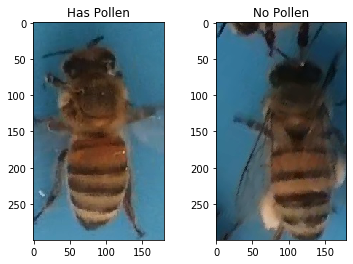

In [15]:
fig, axes = plt.subplots(1,2)
k=0
plt.sca(axes[0])
plt.imshow(X[k])
plt.title('Has Pollen'.format(k, Y[k]))

k=400
plt.sca(axes[1])
plt.imshow(X[k])
plt.title('No Pollen'.format(k, Y[k]));

*Goal*: Classify the bees that have pollen and those that do not.

## 1

Train a model from scratch using what little data you have without any regularization, to set a baseline for what can be achieved.

---

The first step in training the model is splitting the train and validation data.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=18)

partial_x_train, validation_x_train, partial_y_train, validation_y_train = train_test_split(
    x_train, y_train, test_size=0.15, random_state=18)

With this, we can compile a model composed of the convolution layers. 

In [17]:
verbose = 0
epochs = 30
batch_size = 32
learning_rate = 1e-4
with tf.device('/gpu:0'):
    # input
    input_layer = Input(shape=(300, 180, 3))

    # conv layers
    conv_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    conv_layer1 = MaxPool2D( (2, 2), padding='same')(conv_layer1)

    conv_layer2 = Conv2D(64, (3, 3), activation='relu')(conv_layer1)
    conv_layer2 = MaxPool2D( (2, 2), padding='same')(conv_layer2)

    conv_layer3 = Conv2D(128, (3, 3), activation='relu')(conv_layer2)
    conv_layer3 = Conv2D(128, (3, 3), activation='relu')(conv_layer3)
    conv_layer3 = MaxPool2D( (2, 2), padding='same')(conv_layer3)

    conv_layer4 = Conv2D(256, (3, 3), activation='relu')(conv_layer3)
    conv_layer4 = Conv2D(256, (3, 3), activation='relu')(conv_layer4)
    conv_layer4 = MaxPool2D( (2, 2), padding='same')(conv_layer4)

    # flatten and dense layers
    flatten_layer = Flatten()(conv_layer3)
    dense_layer = Dense(512, activation='relu')(flatten_layer)

    # output
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    model_1 = Model(input_layer, output_layer)
    model_1.compile(
        optimizer=RMSprop(lr=learning_rate), 
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    if verbose==1:
        print(model_1.summary())

    history_1 = model_1.fit(
        partial_x_train, 
        partial_y_train,
        validation_data=(validation_x_train, validation_y_train),
        epochs=epochs, 
        batch_size=batch_size, 
        verbose=verbose
    )

In [18]:
model_1.save_weights("part1-1.h5")
with open('history_1.json', 'w') as fp:
    json.dump(history_1.history, fp)

In [19]:
with open('history_1.json') as fp:
    history = json.load(fp)

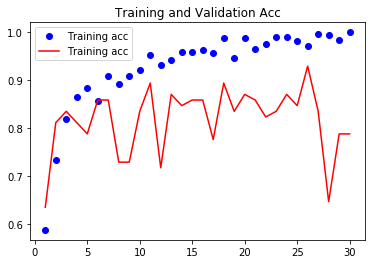

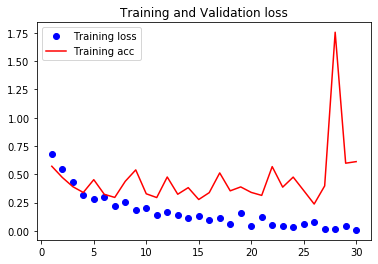

In [20]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Validation acc')
plt.legend()
plt.title('Training and Validation Acc')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [21]:
test_loss, test_acc = model_1.evaluate(x_test, y_test, steps=10)
print('The final test accuracy: ',test_acc)

10/10 [==============================] - 93s 9s/step
The final test accuracy:  0.8865247964859009


## 2

Use data augmentation to generate more training data from your existing training samples. Also add a Dropout layer to your model, right before the densely connected classifier.

In [22]:
df = pd.DataFrame(
    {
        "label":[str(y) for y in Y],
        "file_name":imlist
    }
)

In [23]:
with tf.device('/gpu:0'):
    # input
    input_layer = Input(shape=(300, 180, 3))

    # conv layers
    conv_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    conv_layer1 = MaxPool2D( (2, 2), padding='same')(conv_layer1)

    conv_layer2 = Conv2D(64, (3, 3), activation='relu')(conv_layer1)
    conv_layer2 = MaxPool2D( (2, 2), padding='same')(conv_layer2)

    conv_layer3 = Conv2D(128, (3, 3), activation='relu')(conv_layer2)
    conv_layer3 = Conv2D(128, (3, 3), activation='relu')(conv_layer3)
    conv_layer3 = MaxPool2D( (2, 2), padding='same')(conv_layer3)

    conv_layer4 = Conv2D(256, (3, 3), activation='relu')(conv_layer3)
    conv_layer4 = Conv2D(256, (3, 3), activation='relu')(conv_layer4)
    conv_layer4 = MaxPool2D( (2, 2), padding='same')(conv_layer4)

    # flatten and dense layers
    flatten_layer = Flatten()(conv_layer3)
    flatten_layer = Dropout(0.5)(flatten_layer)
    dense_layer = Dense(512, activation='relu')(flatten_layer)

    # output
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    model_2 = Model(input_layer, output_layer)
    model_2.compile(
        optimizer=RMSprop(lr=1e-4), 
        loss='binary_crossentropy',
        metrics=['accuracy'])
    if verbose==1:
        print(model_2.summary())
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    datagen.fit(partial_x_train)
    history_2 = model_2.fit_generator(
        datagen.flow_from_dataframe(
            dataframe=df,
            directory="./",
            x_col="file_name",
            y_col="label",
            class_mode="binary"
        ),
        steps_per_epoch=len(partial_x_train) / batch_size,
        epochs=epochs,
        verbose=verbose
    )

W0920 12:46:37.521336 18256 deprecation.py:506] From C:\Users\saxen\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Found 702 validated image filenames belonging to 2 classes.


TypeError: '<' not supported between instances of 'int' and 'range'

In [24]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(partial_x_train)
history_2 = model_2.fit_generator(
    datagen.flow(
        partial_x_train, 
        partial_y_train, 
        batch_size=batch_size
    ),
    steps_per_epoch=len(partial_x_train) / batch_size,
    epochs=epochs,
    verbose=verbose
)

TypeError: '<' not supported between instances of 'int' and 'range'

In [25]:
model_2.save_weights("part1-2.h5")
with open('history_2.json', 'w') as fp:
    json.dump(history_2.history, fp)

NameError: name 'history_2' is not defined

In [35]:
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation Acc')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

NameError: name 'history_2' is not defined

In [36]:
test_loss, test_acc = model_2.evaluate(x_test, y_test, steps=10)
print('The final test accuracy: ',test_acc)

10/10 [==============================] - 52s 5s/step
The final test accuracy: 0.6028369069099426


### Question 1: Part 3- Use one of the pretrained image-classification models prepackaged in Keras trained on ImageNet dataset. The list includes Xception, Inception V3,ResNet50, VGG16, VGG19, and MobileNet. You can import these from the keras.applications module.

In [27]:
#from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import applications
from keras.applications.vgg16 import VGG16

In [28]:
img_width = 300
img_height = 180
model_3 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [30]:
# Freeze the first few layers of the VGG16 model to use the original weights and not change them
for layer in model_3.layers[:30]:
    layer.trainable = False

In [32]:
#Adding custom Layers 
x = model_3.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

In [35]:
# creating the final model 
model_3 = Model(input = model_3.input, output = predictions)

C:\Users\saxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [36]:
model_3.compile(
    optimizer=RMSprop(lr=1e-4), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [38]:
epochs = 100
batch_size = 25
vgg16 = model_3.fit(
    partial_x_train, 
    partial_y_train,
    validation_data=(validation_x_train, validation_y_train),
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1
)